# Text Clustering and Topic Modeling

# 1. Text Clustering

## 1.1 The goal

Text clustering is an unsupervised technique that aims to group similar texts based on their content, meaning and relationships.

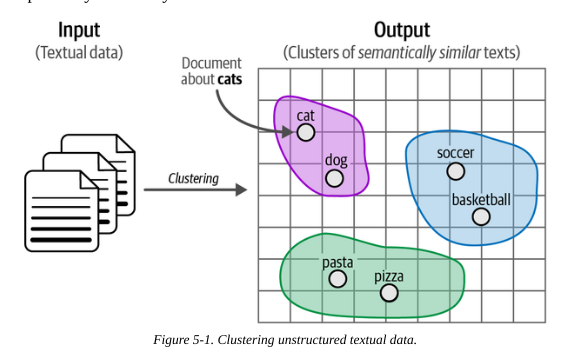

The clusters can the be used for applications such as outlier detection, speeding up labelling and finding mislabelled data.

It also has applications in **topic modelling**, where we assign a label or keywords to a cluster describing its constituents.


We apply this to an example data set of Arxiv articles. Let's load the Arxiv data we'll use for this:


In [1]:
from datasets import load_dataset


dataset = load_dataset("maartengr/arxiv_nlp")["train"]
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

Generating train split: 0 examples [00:00, ? examples/s]

## 1.2. Text clustering pipeline

There are many approaches to text clustering, including GNNs and centroid-based clustering. A common approach is:

1. Convert input documents to **embeddings**, using an *embedding model*
2. **Reduce the dimensionality** of those embeddings, using a *dimensionality reduction model*
3. **Group similar documents**, using a *cluster model*


### 1.2.1. The embedding model

We convert our text to embedding vectors using an embedding model. We should choose one that was trained to optimise *semantic similarity* (which most are). We can use the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) to help select a good model.

We can load a pre-trained model and create our embeddings.


In [5]:
from sentence_transformers import SentenceTransformer 

embedding_model = SentenceTransformer("thenlper/gte-small") 
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

### 1.2.2. The dimensionality reduction model

High-dimensional data can suffer from the **curse of dimensionality**, making it difficult to find meaningful clusters.

We can use a dimensionality reduction model to *compress* (not remove) dimensions which makes the downstream clustering easier.

This is, by it’s nature, a lossy transformation. But we hope that *enough* of the information is retained to be useful.

Standard dimensionality reduction techniques include Principal Component Anaylsis (PCA) and Uniform Manifold Approximation (UMAP). We’ll use UMAP as it tends to handle nonlinear relationships better.

The following code reduces our embeddings from 384 -> 5 dimensions. We set `min_dist=0` as this allows embedded points to be arbitrarily close together, which results in tighter clusters, and `metric=‘cosine’` generally performs better than Euclidean methods for high-dimensional data.

In [7]:
from umap import UMAP

umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### 1.2.3. The cluster model

**Centroid-based** algorithms like K-Nearest Neighbours (KNN) are popular in other settings but require us to specify the number of clusters ahead of time (which we don’t know) and forces all data points to be part of a cluster (there can’t be unassigned points). This makes them less useful for our use case.

**Density-based** algorithms calculate the number of clusters freely and do not force all points into a cluster. We’ll use HDBSCAN for our case.

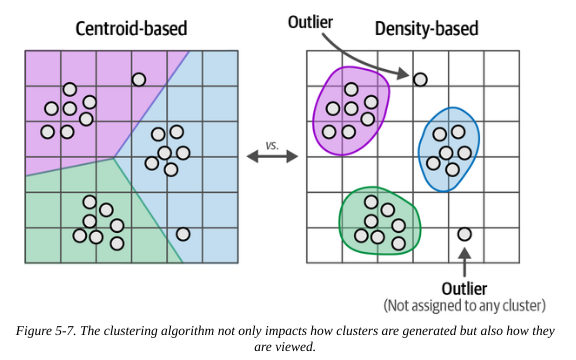

We can cluster the data with the following code. We can vary `min_cluster_size` to change the number of clusters produced.


In [8]:
from hdbscan import HDBSCAN 

hdbscan_model = HDBSCAN(min_cluster_size=50, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this war

We can inspect the clusters and plot the data in the reduced dimension space. Although helpful, it’s worth remembering that this is just an approximation of the real embeddings, some information is lost.


First, let's observe a selection of 3 documents from the first cluster to see if they seem similar:

In [9]:
import numpy as np 


# Print first three documents in cluster 0 
cluster = 0 
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Now we can plot the data in the reduced embedding space:

In [10]:
import pandas as pd 


# Reduce 384-dimensional embeddings to two dimensions for easier visualization 
reduced_embeddings = UMAP(n_components=2, min_dist=0.0, metric="cosine", random_state=42 ).fit_transform(embeddings) 

df = pd.DataFrame(reduced_embeddings, columns=["x", "y"]) 
df["title"] = titles 
df["cluster"] = [str(c) for c in clusters] 

# Select outliers and non-outliers (clusters) 
to_plot = df.loc[df.cluster != "-1", :] 
outliers = df.loc[df.cluster == "-1", :]

/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-7.562705826759339,
 10.960084271430969,
 -3.4470335602760316,
 18.276195919513704)

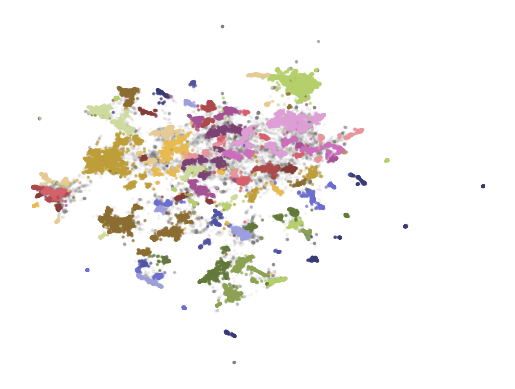

In [11]:
import matplotlib.pyplot as plt 


# Plot outliers and non-outliers separately 
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey") 
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int), alpha=0.6, s=2, cmap="tab20b" ) 
plt.axis("off")

# 2. Topic Modelling

This is where we find themes or latent topics in a cluster; we want to find keywords or phrases that best represent the topic.

Classical approaches to topic modelling include latent Dirichlet allocation (LDA), where it’s assumed that each topic is characterised by a probability distribution of words in a corpus. These are generally *bag-of-words* approaches that do not account for context or meaning.

An LLM-based approach is the modular **BERTopic**.

## 2.1. BERTopic

The first step is to perform text clustering using the same 3 steps outlined in the previous section.

We then use a bag-of-words approach *per cluster* (instead of per document as would usually be the case) to model a distribution over words per class. This is the **CountVectorizer** step.

We similarly use a class-specific variant of term-frequency inverse document-frequency called **c-TF-IDF**, which puts more weight on the meaningful words of that cluster. 


We now have a generic **text clustering pipeline**:

```{mermaid}
flowchart LR

  A(Embeddings) --> B(Dimensionality Reduction) --> C(Clustering)
```

And a **topic modeling pipeline**:
```{mermaid}
flowchart LR

  D(Cluster Bag-of-Words) --> E(Keyword Selection)
```

Putting this all together with our choice of components:

```{mermaid}
flowchart LR

  A(SBERT) --> B(UMAP) --> C(HDBSCAN) --> D(CountVectorizer) --> E(c-TF-IDF)
```

The idea behind BERTopic is that these components are codular, so each can be swapped out like lego blocks. For example, if you prefer k-means clusters or PCA over UMAP, just swap it.

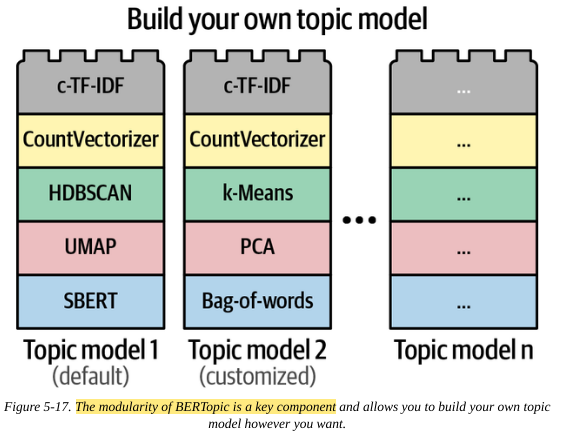

This modularity also means the same base model can be used and adapted for different tasks and use cases by adding/removing components downstream of the base model.


### 2.1.1. Create a BERTopic model

We can run this end-to-end pipeline using the previously defined models in BERTopic:

In [12]:
from bertopic import BERTopic 

# Train our model with our previously defined models 
topic_model = (BERTopic(embedding_model=embedding_model, 
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        verbose=True)
               .fit(abstracts, embeddings))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-01-15 11:48:19,327 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-15 11:48:47,848 - BERTopic - Dimensionality - Completed ✓
2025-01-15 11:48:47,851 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

### 2.1.2. Explore the topics

We can then explore the topics found by the model.

Note that the topic labelled `-1` is a bucket for outliers that do not fit in any other cluster.

In [13]:
topic_model.get_topic_info()

Topic  Count                                       Name  \
0       -1  13779                           -1_of_the_and_to   
1        0   2224               0_speech_asr_recognition_end   
2        1   2104             1_question_qa_questions_answer   
3        2   1428      2_medical_clinical_biomedical_patient   
4        3    986           3_translation_nmt_machine_neural   
..     ...    ...                                        ...   
146    145     54        145_gans_gan_adversarial_generation   
147    146     54       146_emoji_emojis_emoticons_sentiment   
148    147     51  147_prompt_prompts_optimization_prompting   
149    148     51     148_coherence_discourse_paragraph_text   
150    149     51             149_long_context_window_length   

                                        Representation  \
0    [of, the, and, to, in, we, language, that, for...   
1    [speech, asr, recognition, end, acoustic, spea...   
2    [question, qa, questions, answer, answering, a...   
3    [medical, clinical, biomedical, patient, healt...   
4    [translation, nmt, machine, neural, bleu, engl...   
..                                                 ...   
146  [gans, gan, adversarial, generation, generativ...   
147  [emoji, emojis, emoticons, sentiment, twitter,...   
148  [prompt, prompts, optimization, prompting, llm...   
149  [coherence, discourse, paragraph, text, cohesi...   
150  [long, context, window, length, llms, memory, ...   

                                   Representative_Docs  
0    [  Language models have emerged as a central c...  
1    [  The amount of labeled data to train models ...  
2    [  Multi-hop question answering (QA) requires ...  
3    [  Clinical texts, such as admission notes, di...  
4    [  In this paper, we introduce a hybrid search...  
..                                                 ...  
146  [  Text generation is of particular interest i...  
147  [  The frequent use of Emojis on social media ...  
148  [  Prompt optimization aims to find the best p...  
149  [  While there has been significant progress t...  
150  [  We present a series of long-context LLMs th...  

[151 rows x 5 columns]

We can explore a particular topic by its topic number:

In [14]:
topic_model.get_topic(2)

[('medical', 0.0220337946328463),
 ('clinical', 0.02092442350104087),
 ('biomedical', 0.014552038344966458),
 ('patient', 0.010048801098837407),
 ('health', 0.008769124731484461),
 ('notes', 0.008421182820081155),
 ('patients', 0.0067969193810322485),
 ('healthcare', 0.0067470745955792765),
 ('and', 0.006483211946307094),
 ('drug', 0.006111735386306484)]

We can also search for clusters which match a given search term:

In [18]:
topic_model.find_topics("rocket science")

([131, 46, 28, -1, 9], [0.8482957, 0.8474297, 0.8343923, 0.8332416, 0.8269581])

Topic number 31 allegedly matches the term, so we can look closer at this topic:

In [19]:
topic_model.get_topic(131)

[('materials', 0.050279482237225254),
 ('science', 0.02243336305054669),
 ('chemistry', 0.0215702079363354),
 ('chemical', 0.019510674137408444),
 ('scientific', 0.019096261213199146),
 ('material', 0.01734997997000861),
 ('synthesis', 0.013922383987668636),
 ('literature', 0.011377588070962407),
 ('reaction', 0.010392948527677913),
 ('extraction', 0.009880316014163601)]

### 2.1.3. Visualise the topics

As we did in the "manual" example, we can visualise the text clusters. The library provides a handy convenience method for interactive plotting.

In [20]:
fig = topic_model.visualize_documents( titles, reduced_embeddings=reduced_embeddings, width=1200, hide_annotations=True ) 
fig.update_layout(font=dict(size=16))

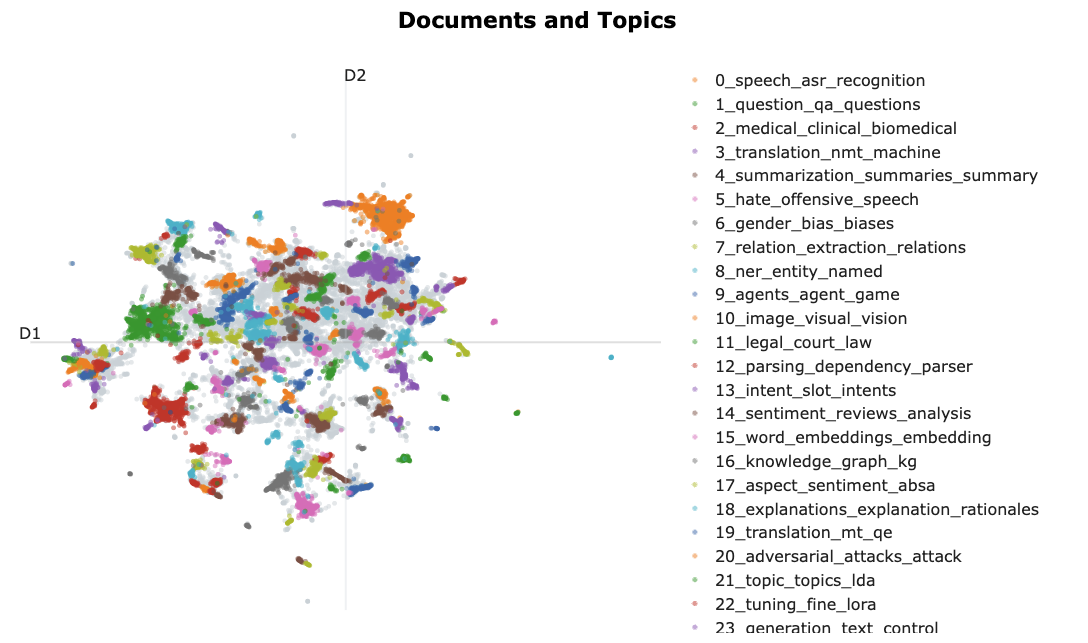

We can also plot keywords per topic:

In [21]:
topic_model.visualize_barchart()

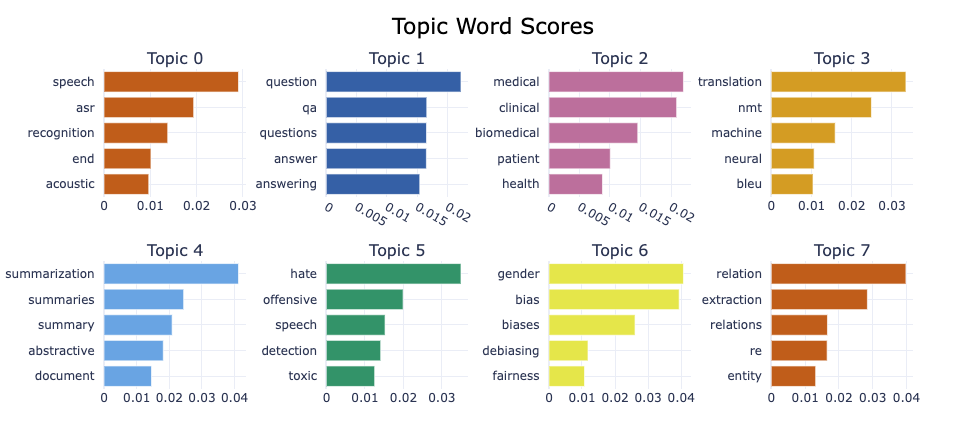

We can plot the similarity between topics as a heatmap:

In [22]:
topic_model.visualize_heatmap(n_clusters=30)

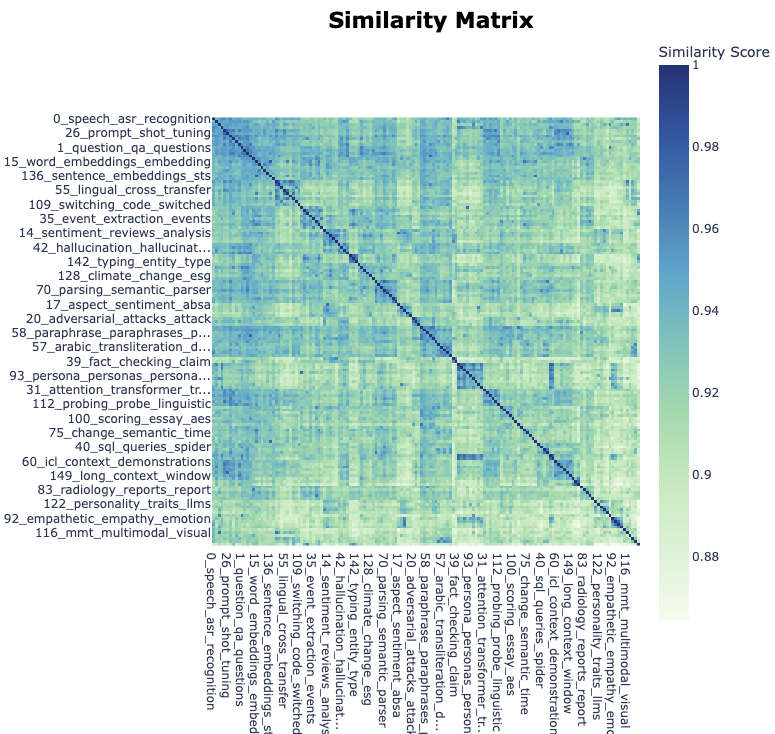

We can also see the hierarchies within topics

In [23]:
topic_model.visualize_hierarchy()

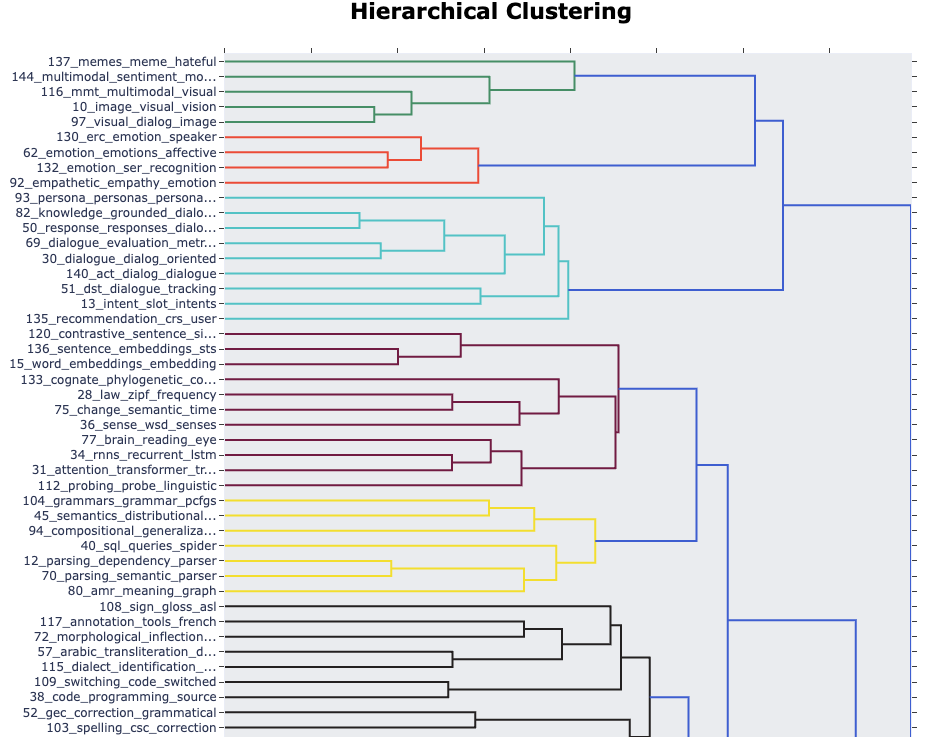

## 2.2. Re-ranking

The pipeline so far relied on the bag-of-words (BoW) approach to identify key words. This is fast, but does not take the semantic structure of a sentence into account.

We _could_ swap the bag-of-words "lego block" for something more sophisticated. Another approach is to instead keep it as is but add an extra "re-ranker" block at the end to fine-tune the ordering of the keywords. This can be a slower algorithm, but it only processes the list of words identified by BoW for each topic (tens or hundreds), not the entire dcoument corpus (millions or more).

These re-rankers are referred to as **representation models**.

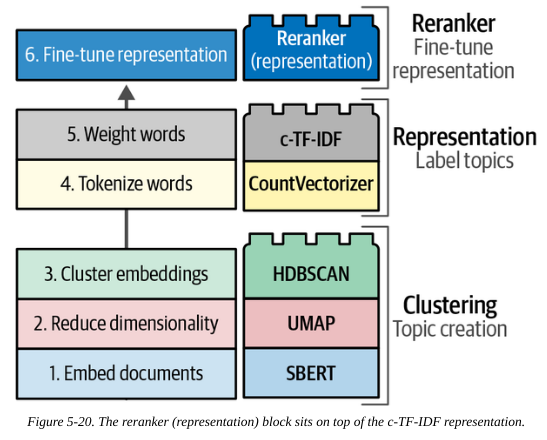


### 2.2.1. KeyBERTInspired

The idea behind this apporach is to use the similarity between embedding and words vectors to give a score, then order key words by their match score.

1. **Average document embedding**: Calculate embeddings for each document, then average
2. Calculate embeddings for each **keyword**
3. Calculate **cosine similarity** between each keyword and the average document embedding
4. Order by the most similar

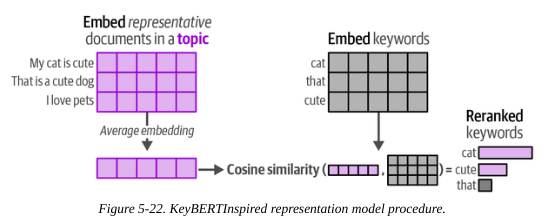


We will save the representations from the previousl model so we can compare them to the re-ranked versions

In [24]:
# Save original representations 
from copy import deepcopy 

 
original_topics = deepcopy(topic_model.topic_representations_)

The following convenience function helps to compare topics between the original and reranked versions.

In [39]:
def topic_differences(model, original_topics, num_topics=5):
    """Show the differences in topic representations between two models"""
    topic_words = []
    for topic in range(num_topics): 
        # Extract top 4 words per topic per model 
        og_words = " | ".join(list(zip(*original_topics[topic])) [0][:4]) 
        reranked_words = " | ".join(list(zip(*model.get_topic(topic))) [0][:4]) 
        topic_words.append((topic, og_words, reranked_words,))
    
    return pd.DataFrame(columns=["Topic", "Original", "Reranked"], data=topic_words)

In [25]:
from bertopic.representation import KeyBERTInspired 


# Update our topic representations using KeyBERTInspired 
representation_model = KeyBERTInspired() 
topic_model.update_topics(abstracts, representation_model=representation_model)

In [41]:
# Show topic differences 
topic_differences(topic_model, original_topics, num_topics=10)

Topic                                           Original  \
0      0                   speech | asr | recognition | end   
1      1                 question | qa | questions | answer   
2      2          medical | clinical | biomedical | patient   
3      3               translation | nmt | machine | neural   
4      4  summarization | summaries | summary | abstractive   
5      5              hate | offensive | speech | detection   
6      6                 gender | bias | biases | debiasing   
7      7             relation | extraction | relations | re   
8      8                 ner | entity | named | recognition   
9      9                      agents | agent | game | games   

                                            Reranked  
0       transcription | phonetic | speech | language  
1  answering | comprehension | retrieval | questions  
2                   nlp | clinical | text | language  
3  translation | translate | translations | multi...  
4  summarization | summarizers | summaries | abst...  
5          hate | hateful | language | cyberbullying  
6                  gendered | gender | bias | biases  
7     relation | relations | relational | extracting  
8                 entity | entities | labeled | name  
9                     reasoning | ai | game | agents

### 2.2.2. Maximal Marginal Relevance

TODO: p 226 onwards

## 2.3. Text Generation



# References

- Chapter 5 of Hands On LLMs
- [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
- [BERT best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html)